# Kaggle - Survival on the Titanic

# 1. Introduction

The purpose of this notebook is to predict whether or not a passenger survived the Titanic accident.

## 1.1. Packages and data

In [635]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

from sklearn.ensemble import RandomForestClassifier

In [636]:
# Import data as Pandas data frames
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [637]:
print(train.info())
print("**********************************")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
**********************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null 

As shown above, the data set contains missing data. Several features also need to be converted to be using in our model.

In [638]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The purpose of this project is to use all (or most) the features of the data set in order to predict the survival of a given passenger.

## 1.2 Pivoting features

Based on common sense, we can expect that the passenger's sex, age, and family size will have the strongest correlation with the survival rate. Let's confirm these assumptions.

**Gender**

In [639]:
train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived',ascending =False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


**Class**

In [640]:
train[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean().sort_values(by='Survived',ascending =False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


**Family**

In [641]:
Sib_Sb_df=train[['SibSp','Survived']].groupby(['SibSp'],as_index=False).mean().sort_values(by='Survived',ascending =False)
Sib_Sb_df

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


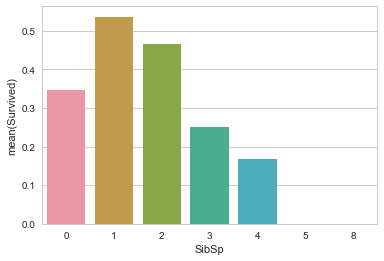

In [642]:
sns.barplot(x='SibSp',y='Survived',data=Sib_Sb_df)

In [643]:
Parch_df=train[['Parch','Survived']].groupby(['Parch'],as_index=False).mean().sort_values(by='Survived',ascending =False)
Parch_df

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


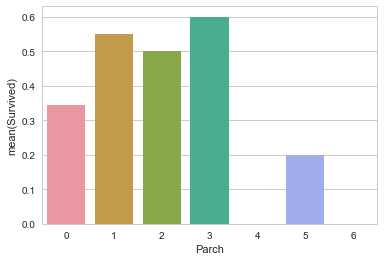

In [644]:
sns.barplot(x='Parch',y='Survived',data=Parch_df)

In conclusion:
 - *Sex*, Females have a higher change of survival over men (74% vs. 19%)
 - *Pclass*, the survival rate is strongly correlated with the passenger class
 - *SibSp*, *Parch*, smaller family tends to have a higher survival rate

## 1.3 Data Visualization

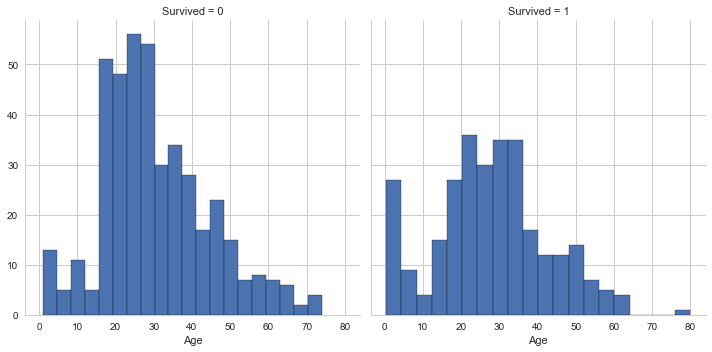

In [645]:
g = sns.FacetGrid(train, col='Survived',size=5)
g.map(plt.hist, 'Age', bins=20,ec='black')

 - Children had a high survival rate.
 - All passenger older than 75 survived.
 - Most casualties were older than 25.

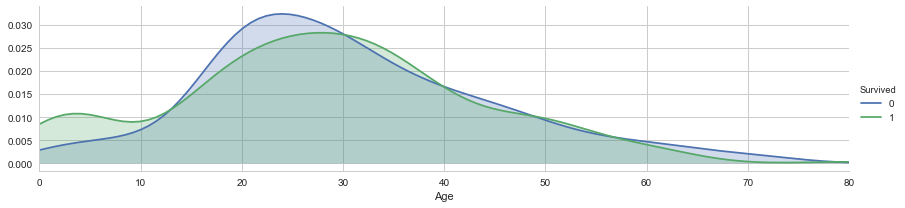

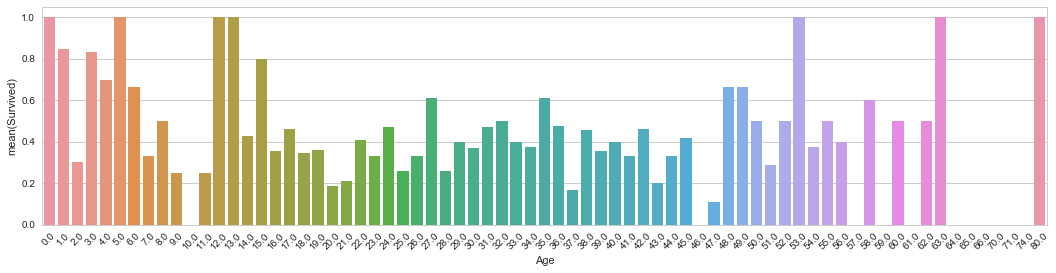

In [646]:
# We will now review the data presented above using other tools

facet = sns.FacetGrid(data=train,hue='Survived',aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

# Survival rate per age
# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age=train[["Age", "Survived"]].copy()
average_age.Age=average_age.Age.round(0)
average_age = average_age.groupby(['Age'],as_index=False).mean()

g = sns.barplot(x='Age', y='Survived', data=average_age)
plt.xticks(rotation=45);

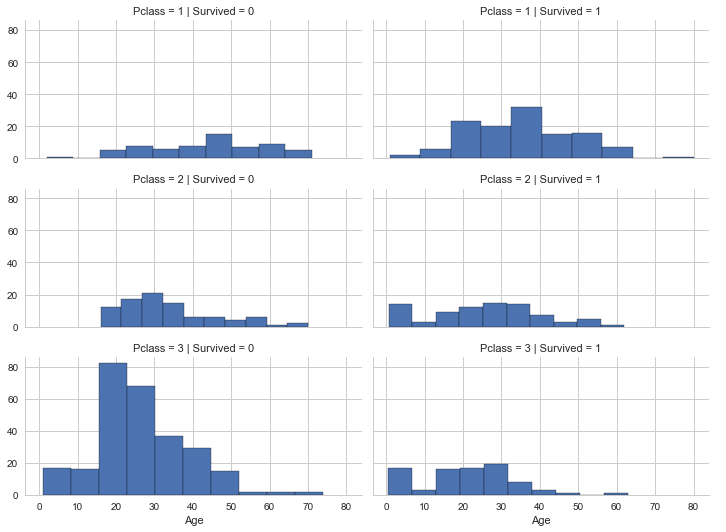

In [647]:
grid = sns.FacetGrid(train,row='Pclass',col='Survived',size=2.5, aspect=2)
grid.map(plt.hist,'Age',ec='black')
grid.add_legend();

 - The age distribution varies per class.
 - Most passengers from the first class survived.
 - Young passengers from the second and third class survived.

## 1.4. Correlation of categorical features

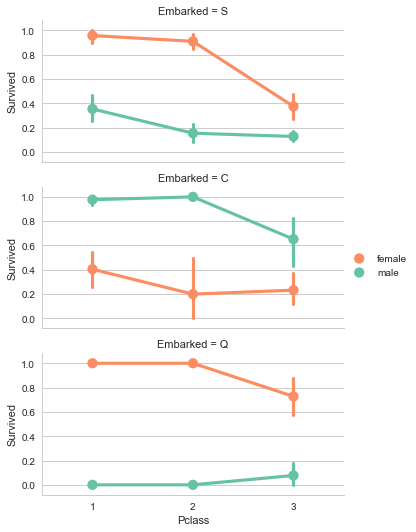

In [648]:
grid = sns.FacetGrid(train, row='Embarked', size=2.5, aspect=2.0)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex',palette="Set2")
grid.add_legend();

 - Except from Embarked=C, females had a higher survival rate.
 - The Embarked feature when combined with the Sex and Pclass is highly correlated with the survival rate.

# 2. Data wrangling
Now that we have a better understanding of the correlation between the survival rate and the different features of the dataset, we can make decision regarding the missing value and also create new features.

## 2.1. New features
Even though the Name feature cannot be used as such, it contains the title of the passenger. This additional feature might present a correlation with the survival rate.  
Note: the targetted substring is located between a space character and a period.

We will first investigate the correlation between the passenger's title and his/her survival rate.

In [649]:
# Extract the passenger title
train['Title'] = train.Name.str.extract(r' ([A-Za-z]+)\.',expand=False)
test['Title'] = test.Name.str.extract(r' ([A-Za-z]+)\.',expand=False)
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Lady          1
Ms            1
Jonkheer      1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Name: Title, dtype: int64

In [650]:
# Investigate survival based on title
train['Survived'].groupby(train['Title']).mean()

Title
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

As shown above, several title possess a high survival rate. We will account for it in our model. We will now investigate the correlation between the passenger's name and his/her survival rate.

In [651]:
# Determine if correlation can be found between name length and survival rate
train['Name_Len'] = train['Name'].apply(lambda x: len(x))
train['Survived'].groupby(pd.qcut(train['Name_Len'],5)).mean()

Name_Len
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64

In [652]:
pd.qcut(train['Name_Len'],5).value_counts()

(11.999, 19.0]    204
(23.0, 27.0]      197
(32.0, 82.0]      169
(27.0, 32.0]      165
(19.0, 23.0]      156
Name: Name_Len, dtype: int64

Again, it appears that the survival rate is positively correlated to the passenger's name length.  
The next feature that we will investigate is the ticket ID. Even if the available data does not help locating the passenger on the boat, a pattern in the ticket ID can help us.

In [653]:
train['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [654]:
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
train['Ticket_Len'].value_counts()

6     419
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_Len, dtype: int64

One specific aspect of the ticket ID appears to be helpful. A large portion of the tickets seem to start with a letter, other are simply made of digits.

In [655]:
train['Ticket_Lett'] = train['Ticket'].apply(lambda x: str(x)[0])

In [656]:
train['Ticket_Lett'].value_counts()

3    301
2    183
1    146
P     65
S     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_Lett, dtype: int64

In [657]:
train.groupby(['Ticket_Lett'])['Survived'].mean().sort_values(ascending=False)

Ticket_Lett
9    1.000000
P    0.646154
1    0.630137
F    0.571429
2    0.464481
C    0.340426
S    0.323077
L    0.250000
3    0.239203
4    0.200000
6    0.166667
W    0.153846
7    0.111111
A    0.068966
8    0.000000
5    0.000000
Name: Survived, dtype: float64

In conclusion, the ticket fare can be integrated in our model by using the first character of the ticket ID. The fare is now investigated.

In [658]:
pd.qcut(train['Fare'], 5).value_counts()

(7.854, 10.5]        184
(21.679, 39.688]     180
(-0.001, 7.854]      179
(39.688, 512.329]    176
(10.5, 21.679]       172
Name: Fare, dtype: int64

In [659]:
train['Survived'].groupby(pd.qcut(train['Fare'], 5)).mean()

Fare
(-0.001, 7.854]      0.217877
(7.854, 10.5]        0.201087
(10.5, 21.679]       0.424419
(21.679, 39.688]     0.444444
(39.688, 512.329]    0.642045
Name: Survived, dtype: float64

In [660]:
pd.crosstab(pd.qcut(train['Fare'], 5), columns=train['Pclass'])

Pclass,1,2,3
Fare,,,
"(-0.001, 7.854]",6,6,167
"(7.854, 10.5]",0,24,160
"(10.5, 21.679]",0,80,92
"(21.679, 39.688]",64,64,52
"(39.688, 512.329]",146,10,20


The survival rate is positively correlated with the fare. Moreover, as expected, the class is also correlated with the fare. We will now investigate the embarkation feature.

In [661]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [662]:
train['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

In [663]:
train['Survived'].groupby(train['Embarked']).mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

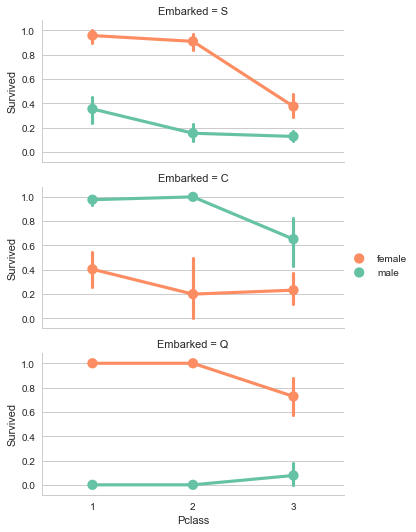

In [664]:
grid = sns.FacetGrid(train, row='Embarked', size=2.5, aspect=2.0)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex',palette="Set2")
grid.add_legend();

In conclusion, most passengers embarked at station S. When combining the class, gender, and embarkation, we discovered that different population have a higher survival rate depending on the combination of these three features.

Finally, we will investigate the survival rate using the cabin name.

In [665]:
train[train.Cabin.notnull()][['Survived','Cabin']].head(10)

,Survived,Cabin
1,1,C85
3,1,C123
6,0,E46
10,1,G6
11,1,C103
21,1,D56
23,1,A6
27,0,C23 C25 C27
31,1,B78
52,1,D33


The cabin ID is made of a letter character and a combination of digits. We create a new feature based on the first letter (which might be the bridge number).

In [666]:
train['Cabin_Lett'] = train['Cabin'].apply(lambda x: str(x)[0])

In [667]:
train['Cabin_Lett'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Lett, dtype: int64

In [668]:
train['Survived'].groupby(train['Cabin_Lett']).mean()

Cabin_Lett
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

A correlation exists between the first letter and the survival rate. We will include this feature in our model. We will now investigate the cabin number.

In [669]:
# Several record contains multiple cabin number, we will focus on the first one.
train['Cabin_num'] = train['Cabin'].apply(lambda x: str(x).split(' ')[0][1:])
train['Cabin_num'].unique()

array(['an', '85', '123', '46', '6', '103', '56', '23', '78', '33', '30',
       '52', '28', '83', '', '31', '5', '10', '26', '110', '58', '101',
       '47', '86', '2', '19', '7', '49', '4', '32', '80', '36', '15', '93',
       '35', '87', '77', '67', '94', '125', '99', '118', '22', '106', '65',
       '54', '57', '34', '18', '124', '91', '40', '128', '37', '50', '82',
       '96', '44', '104', '111', '92', '38', '21', '12', '63', '14', '20',
       '79', '25', '73', '95', '39', '70', '16', '68', '41', '9', '48',
       '126', '71', '51', '62', '24', '90', '45', '8', '121', '11', '3',
       '17', '102', '69', '42', '148'], dtype=object)

Two records are not valid ("an" and ""). We will replace them with NaN.

In [670]:
train['Cabin_num'].replace('an', np.NaN, inplace = True)
train['Cabin_num'] = train['Cabin_num'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)

In [671]:
train['Cabin_num'].describe()

count    196.000000
mean      50.102041
std       35.645402
min        2.000000
25%       22.000000
50%       40.500000
75%       78.000000
max      148.000000
Name: Cabin_num, dtype: float64

In [672]:
pd.qcut(train['Cabin_num'],3).value_counts()

(1.999, 28.0]    67
(62.0, 148.0]    65
(28.0, 62.0]     64
Name: Cabin_num, dtype: int64

In [673]:
train['Survived'].groupby(pd.qcut(train['Cabin_num'], 3)).mean()

Cabin_num
(1.999, 28.0]    0.716418
(28.0, 62.0]     0.687500
(62.0, 148.0]    0.630769
Name: Survived, dtype: float64

In [674]:
train['Survived'].corr(train['Cabin_num'])

-0.054868500871151277

## 2.2 Cleaning functions

Now that we have a good understanding of the correlation between the provided features and the survival rate, we will create functions to clean the data set and add the new features presented in Section 2.1.

In [675]:
def names(train, test):
    '''
    Create the Name_Len and Title feature
    '''
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].str.extract(r' ([A-Za-z]+)\.',expand=False)
        del i['Name']
    return train, test

In [676]:
def age_fill(train, test):
    '''
    Replace the missing age values by the median value considering a grouping using the title, class, gender.
    '''
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title','Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.median()))
    return train, test

In [677]:
def family_size(train, test):
    '''
    Create a family size feature which is defined as the sum of the SibSp and Parch features
    '''
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Small', 'Large'))
        del i['SibSp']
        del i['Parch']
    return train, test

In [678]:
def ticket_features(train, test):
    '''
    Create the Ticket_Lett feature and group it for the low survival rate.
    '''
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', 'F','S', 'P', 'C','9']), i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['A','W','3','4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test


In [679]:
def cabin_lett(train, test):
    '''
    Create the Cabin_Lett feature.
    '''
    for i in [train, test]:
        i['Cabin_Lett'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [680]:
def cabin_num(train, test):
    '''
    Convert the cabin number using the quantile group and get_dummies sub.
    '''
    for i in [train, test]:
        # Extract first cabin number
        i['Cabin_num_1st'] = i['Cabin'].apply(lambda x: str(x).split(' ')[0][1:])
        # Fill missing value and convert to int when possible
        i['Cabin_num_1st'].replace('an', np.NaN, inplace = True)
        i['Cabin_num_1st'] = i['Cabin_num_1st'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num_1st'],5)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num_1st']
    del test['Cabin_num_1st']
    return train, test

In [681]:
def embarked_station(train, test):
    '''
    Replace missing value with most common value
    '''
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna(i['Embarked'].mode()[0])
    return train, test

In [682]:
def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Lett', 'Name_Title', 'Family_Size']):
    '''
    Convert categorical features into dummies.
    '''
    for column in columns:
        #Convert features in strings
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        
        # Create unique feature name using the unique values of each feature (inner train and test)
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        
        # Concat the dummies to the main DF and delete the original columns
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

In [683]:
def drop(train, test, to_drop):
    '''
    Drop listed features
    '''
    for i in [train, test]:
        for z in to_drop:
            del i[z]
    return train, test

In [684]:
# Apply cleaning and feature conversion

train = pd.read_csv(os.path.join('./', 'train.csv'))
test = pd.read_csv(os.path.join('./', 'test.csv'))
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin_lett(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
# Fill missing fare with median fare
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_features(train, test)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett',
                                                                     'Cabin_Lett', 'Name_Title', 'Family_Size'])
train, test = drop(train, test,['PassengerId'])

In [685]:
print(len(train.columns))

52


In [686]:
# Use random forest as predictive model

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=600,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8316


In [687]:
pd.concat((pd.DataFrame(train.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
14,Sex_female,0.117203
13,Sex_male,0.112713
34,Name_Title_Mr,0.102336
1,Fare,0.090070
2,Name_Len,0.085356
0,Age,0.074550
10,Pclass_3,0.043611
9,Ticket_Len,0.034160
36,Name_Title_Miss,0.032379
18,Ticket_Lett_Low_ticket,0.032351


In [688]:
predictions = rf.predict(test)
predictions = pd.DataFrame(predictions, columns=['Survived'])
test = pd.read_csv(os.path.join('./', 'test.csv'))
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv('y_test_rdm_improved.csv', sep=",", index = False)

In [689]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 52 columns):
Survived                   891 non-null int64
Age                        891 non-null float64
Fare                       891 non-null float64
Name_Len                   891 non-null int64
Age_Null_Flag              891 non-null int64
Cabin_num_(1.999, 19.0]    891 non-null uint8
Cabin_num_(19.0, 33.0]     891 non-null uint8
Cabin_num_(33.0, 50.0]     891 non-null uint8
Cabin_num_(50.0, 86.0]     891 non-null uint8
Cabin_num_(86.0, 148.0]    891 non-null uint8
Ticket_Len                 891 non-null int64
Pclass_3                   891 non-null uint8
Pclass_1                   891 non-null uint8
Pclass_2                   891 non-null uint8
Sex_male                   891 non-null uint8
Sex_female                 891 non-null uint8
Embarked_S                 891 non-null uint8
Embarked_C                 891 non-null uint8
Embarked_Q                 891 non-null uint8
Ticket_Lett_Low_t